# Imports

In [1]:
from dqn.dqn import QNetwork, ReplayMemory
from policies.eps_greedy import EpsilonGreedyPolicy
from train_eval.train import train
from envs.bairds import BairdsCounterExample

import random
import numpy as np
import torch
from torch import optim
import gym
import matplotlib.pyplot as plt

# Load the environment

In [2]:
env = BairdsCounterExample()

# Create DQN and policy

In [3]:
seed = 42  # This is not randomly chosen
num_hidden = 128
eps = 0.05

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden, num_in=7, num_out=2)
policy = EpsilonGreedyPolicy(Q_net, 0.05, its=1000)

# Function to run episodes and call training function (with replay memory)

In [4]:
def run_bairds(train, Q, policy, memory, env, num_transitions, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    state_values = []
    state = env.reset()
    
    for i in range(num_transitions):
        # Set epsilon according to number of steps
        policy.set_epsilon(global_steps)
        # Sample an action, next state, reward and done
        a = policy.sample_action(state)
        s_next, r, done, _ = env.step(a)
        # Add the transition to the memory buffer
        memory.push((state, a, r, s_next, done))
        # Perform training on the buffer
        loss = train(Q, memory, optimizer, batch_size, discount_factor)
        # Increase step count and set current state
        global_steps += 1
        state = s_next
        
        # Every 10 actions, calculate all state-action values and store max value for each state
        if i % 10 == 0:
            all_states = torch.eye(7)
            with torch.no_grad():
                Q.eval()
                Q_vals = Q(all_states)
                maxx, _ = torch.max(Q_vals, dim=1)
                state_values.append(maxx)
    return torch.stack(state_values, 1)

# Perform training

In [5]:
num_transitions = 10000
batch_size = 64
discount_factor = 0.99
learn_rate = 1e-3
# To switch off Replay Memory mechanism, simply set size to batch size
memory = ReplayMemory(batch_size)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
state_values = run_bairds(train, Q_net, policy, memory, env, num_transitions, batch_size, discount_factor, optimizer)

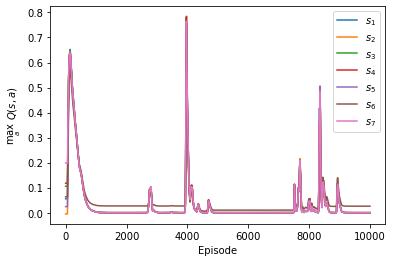

In [6]:
for i in range(7):
    plt.plot(state_values[i])
plt.legend([f'$s_{i}$' for i in range(1,8)])
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 2000, 4000, 6000, 8000, 10000])
plt.ylabel('$\max_a\ Q(s,a)$')
plt.xlabel('Episode')
plt.show()